# 基于LSTM的多资产收益率预测模型

## 项目概述
本项目构建LSTM深度学习模型，对多个金融资产的20日期收益率进行预测。通过构建短期收益率、长期收益率和波动率等特征，捕捉资产收益动态特征。

## 实现流程
1. 数据准备与预处理
   - 读取多资产历史数据
   - 计算对数收益率
2. 特征工程
   - 构建短期(5日)和长期(20日)收益率特征
   - 计算历史波动率
3. 模型构建与训练
   - 搭建LSTM网络结构
   - 针对每个资产单独训练模型
4. 模型评估
   - 计算预测精度指标
   - 可视化预测效果

## 环境依赖
- PyTorch作为Keras后端
- 核心库：keras, pandas, numpy
- 可视化：matplotlib, seaborn

In [1]:
# 配置Keras后端
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 屏蔽TF日志

In [2]:
# 导入所需库
# 数据处理库
import pandas as pd
import numpy as np

# 数据可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 深度学习框架
import torch
import keras
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Reshape, Input, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler

# 模型评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# 检查当前Keras后端
print("当前后端:", keras.backend.backend())

当前后端: torch


In [4]:
# 设置matplotlib显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

# 数据预处理与特征构建

## 数据处理步骤
1. 读取原始资产价格数据
   - 股票指数数据
   - 期货品种数据
   - 无风险利率(R007)数据
2. 数据清洗和计算收益率
   - 计算对数收益率
   - 处理缺失值
3. 构建预测特征
   - 计算滚动时间窗口特征
   - 生成训练数据序列

In [5]:
# 从Excel文件中加载数据
indices = pd.read_excel('资产池行情数据.xlsx', sheet_name='指数数据', header=0, index_col=0, parse_dates=True)
r007 = pd.read_excel('资产池行情数据.xlsx', sheet_name='R007数据', header=0, index_col=0, parse_dates=True)
futures = pd.read_excel('资产池行情数据.xlsx', sheet_name='期货类数据', header=0, index_col=0, parse_dates=True)

# 预处理和合并数据
# 计算R007收益率
annualized_coef = 1 / 365
r007 = ((1 + r007['R007'] / 100) ** annualized_coef - 1).rename('R007_收益率')

# 删除futures中含有缺失值的行
futures.dropna(inplace=True, how='any')

# 合并数据
assets = pd.merge(indices, futures, how='inner', left_index=True, right_index=True)

In [6]:
assets.head(10)

,沪深300,中证500,中证1000,大盘价值,小盘成长,恒生指数,中债国债总指数(7-10年)财富指数,南华工业品,标普500,纳斯达克100,布油,十年美债,沪金
2008-01-09,5613.758,5356.48,4884.27,7369.5322,4508.8751,27615.8500,114.2991,2183.721,1409.13,1949.20,77.718375,120.002755,224.74
2008-01-10,5672.154,5382.33,4894.59,7459.3015,4536.6797,27230.8600,114.2213,2165.709,1420.33,1953.64,75.947743,119.320736,217.68
2008-01-11,5699.147,5376.80,4867.47,7507.1734,4531.2963,26867.0098,114.3680,2186.840,1401.02,1912.81,75.000661,119.970278,217.79
2008-01-14,5731.757,5445.10,4946.35,7553.5284,4584.2152,26468.1300,114.3696,2187.415,1416.25,1949.15,76.524228,120.035232,219.28
2008-01-15,5696.450,5487.09,4999.92,7521.8148,4627.1209,25837.7800,114.4016,2167.367,1380.95,1894.09,75.053244,120.652296,223.11
2008-01-16,5505.717,5412.91,4957.38,7254.8242,4567.2833,24450.8500,114.4409,2117.386,1373.20,1872.29,73.962402,120.587342,217.51
2008-01-17,5365.624,5270.96,4849.48,7088.5124,4449.5691,25114.9800,114.4613,2131.402,1333.25,1842.10,73.342605,121.123214,215.50
2008-01-18,5414.468,5317.45,4886.73,7150.8164,4490.2334,25201.8700,114.4688,2113.724,1325.19,1844.09,73.739275,121.253122,213.72
2008-01-21,5145.734,5097.23,4680.89,6792.3277,4307.5553,23818.8600,114.6780,2114.695,1325.19,1844.09,72.317874,121.253122,215.20
2008-01-22,4753.868,4661.83,4292.69,6275.9767,3949.8027,21757.6300,114.7723,2055.807,1310.50,1795.61,73.094686,122.454773,207.58


In [7]:
# 计算对数收益率
log_returns = pd.DataFrame()
for column in assets.columns:
    log_returns[f'{column}_收益率'] = np.log(assets[column] / assets[column].shift(1))

asset_returns = log_returns.dropna()
asset_returns = asset_returns.iloc[:, [0, 5, 6, 7, 9, 10, 11, 12]]

# 将R007收益率与资产收益率数据合并
log_returns.dropna(inplace=True, how='all')
log_returns = pd.merge(log_returns, r007, left_index=True, right_index=True, how='left')
log_returns.ffill(inplace=True)  # 向前填充缺失值

In [8]:
log_returns.head(10)

,沪深300_收益率,中证500_收益率,中证1000_收益率,大盘价值_收益率,小盘成长_收益率,恒生指数_收益率,中债国债总指数(7-10年)财富指数_收益率,南华工业品_收益率,标普500_收益率,纳斯达克100_收益率,布油_收益率,十年美债_收益率,沪金_收益率,R007_收益率
2008-01-10,0.010349,0.004814,0.002111,0.012108,0.006148,-0.014039,-0.000681,-0.008283,0.007917,0.002275,-0.023046,-0.005700,-0.031918,0.000066
2008-01-11,0.004748,-0.001028,-0.005556,0.006397,-0.001187,-0.013452,0.001284,0.009710,-0.013689,-0.021121,-0.012549,0.005429,0.000505,0.000055
2008-01-14,0.005706,0.012623,0.016076,0.006156,0.011611,-0.014958,0.000014,0.000263,0.010812,0.018820,0.020110,0.000541,0.006818,0.000056
2008-01-15,-0.006179,0.007682,0.010772,-0.004207,0.009316,-0.024104,0.000280,-0.009207,-0.025241,-0.028655,-0.019410,0.005128,0.017315,0.000066
2008-01-16,-0.034056,-0.013611,-0.008545,-0.036141,-0.013016,-0.055173,0.000343,-0.023331,-0.005628,-0.011576,-0.014641,-0.000539,-0.025420,0.000069
2008-01-17,-0.025774,-0.026574,-0.022006,-0.023191,-0.026111,0.026800,0.000178,0.006598,-0.029524,-0.016256,-0.008415,0.004434,-0.009284,0.000074
2008-01-18,0.009062,0.008781,0.007652,0.008751,0.009097,0.003454,0.000066,-0.008329,-0.006064,0.001080,0.005394,0.001072,-0.008294,0.000071
2008-01-21,-0.050907,-0.042297,-0.043035,-0.051433,-0.041534,-0.056440,0.001826,0.000459,0.000000,0.000000,-0.019464,0.000000,0.006901,0.000074
2008-01-22,-0.079209,-0.089289,-0.086575,-0.079065,-0.086705,-0.090513,0.000822,-0.028242,-0.011147,-0.026641,0.010684,0.009861,-0.036051,0.000102
2008-01-23,0.045489,0.052285,0.040728,0.050975,0.052682,0.101839,0.005577,0.011515,0.021216,-0.003392,-0.020907,0.003178,0.023849,0.000131


In [31]:
log_returns.tail(10)

,沪深300_收益率,中证500_收益率,中证1000_收益率,大盘价值_收益率,小盘成长_收益率,恒生指数_收益率,中债国债总指数(7-10年)财富指数_收益率,南华工业品_收益率,标普500_收益率,纳斯达克100_收益率,布油_收益率,十年美债_收益率,沪金_收益率,R007_收益率
2025-05-09,-0.001751,-0.009062,-0.012418,0.006150,-0.014208,0.004023,0.000471,0.002385,-0.000712,-0.000105,0.016884,0.000141,-0.016085,0.000043
2025-05-12,0.011491,0.012497,0.013940,0.005262,0.014293,0.029376,-0.003638,0.019084,0.032040,0.039424,0.016296,-0.005940,-0.009920,0.000042
2025-05-13,0.001451,-0.002074,-0.002671,0.008862,-0.001293,-0.018912,0.000914,-0.004048,0.007222,0.015669,0.025383,-0.001704,-0.023126,0.000042
2025-05-14,0.011979,0.003014,0.001521,0.013120,0.001510,0.022777,-0.000107,0.020562,0.001024,0.005716,-0.008137,-0.002276,0.002279,0.000042
2025-05-15,-0.009175,-0.014560,-0.016916,-0.004103,-0.017356,-0.007962,-0.000362,-0.012933,0.004124,0.000779,-0.023887,0.004830,-0.025255,0.000042
2025-05-16,-0.004647,0.000097,0.001828,-0.008748,0.000882,-0.004620,-0.000715,-0.008987,0.006981,0.004308,0.013545,0.000708,0.008844,0.000044
2025-05-19,-0.003075,0.000865,0.004476,-0.001301,-0.000667,-0.000528,0.001080,0.000813,0.000876,0.000891,0.001985,-0.001701,-0.001464,0.000044
2025-05-20,0.005408,0.004634,0.008280,0.005040,0.004589,0.014837,0.000583,-0.001614,-0.003888,-0.003722,-0.002444,0.000567,0.007299,0.000043
2025-05-21,0.004661,0.001835,-0.002254,0.004573,0.001557,0.006159,-0.000308,0.005664,-0.016267,-0.013523,-0.007215,-0.006401,0.018889,0.000043
2025-05-22,-0.000643,-0.009535,-0.010834,0.005429,-0.010523,-0.011968,-0.000224,-0.009861,-0.000445,0.001522,0.000000,0.000000,0.011174,0.000043


In [9]:
asset_returns.head(10)

,沪深300_收益率,恒生指数_收益率,中债国债总指数(7-10年)财富指数_收益率,南华工业品_收益率,纳斯达克100_收益率,布油_收益率,十年美债_收益率,沪金_收益率
2008-01-10,0.010349,-0.014039,-0.000681,-0.008283,0.002275,-0.023046,-0.005700,-0.031918
2008-01-11,0.004748,-0.013452,0.001284,0.009710,-0.021121,-0.012549,0.005429,0.000505
2008-01-14,0.005706,-0.014958,0.000014,0.000263,0.018820,0.020110,0.000541,0.006818
2008-01-15,-0.006179,-0.024104,0.000280,-0.009207,-0.028655,-0.019410,0.005128,0.017315
2008-01-16,-0.034056,-0.055173,0.000343,-0.023331,-0.011576,-0.014641,-0.000539,-0.025420
2008-01-17,-0.025774,0.026800,0.000178,0.006598,-0.016256,-0.008415,0.004434,-0.009284
2008-01-18,0.009062,0.003454,0.000066,-0.008329,0.001080,0.005394,0.001072,-0.008294
2008-01-21,-0.050907,-0.056440,0.001826,0.000459,0.000000,-0.019464,0.000000,0.006901
2008-01-22,-0.079209,-0.090513,0.000822,-0.028242,-0.026641,0.010684,0.009861,-0.036051
2008-01-23,0.045489,0.101839,0.005577,0.011515,-0.003392,-0.020907,0.003178,0.023849


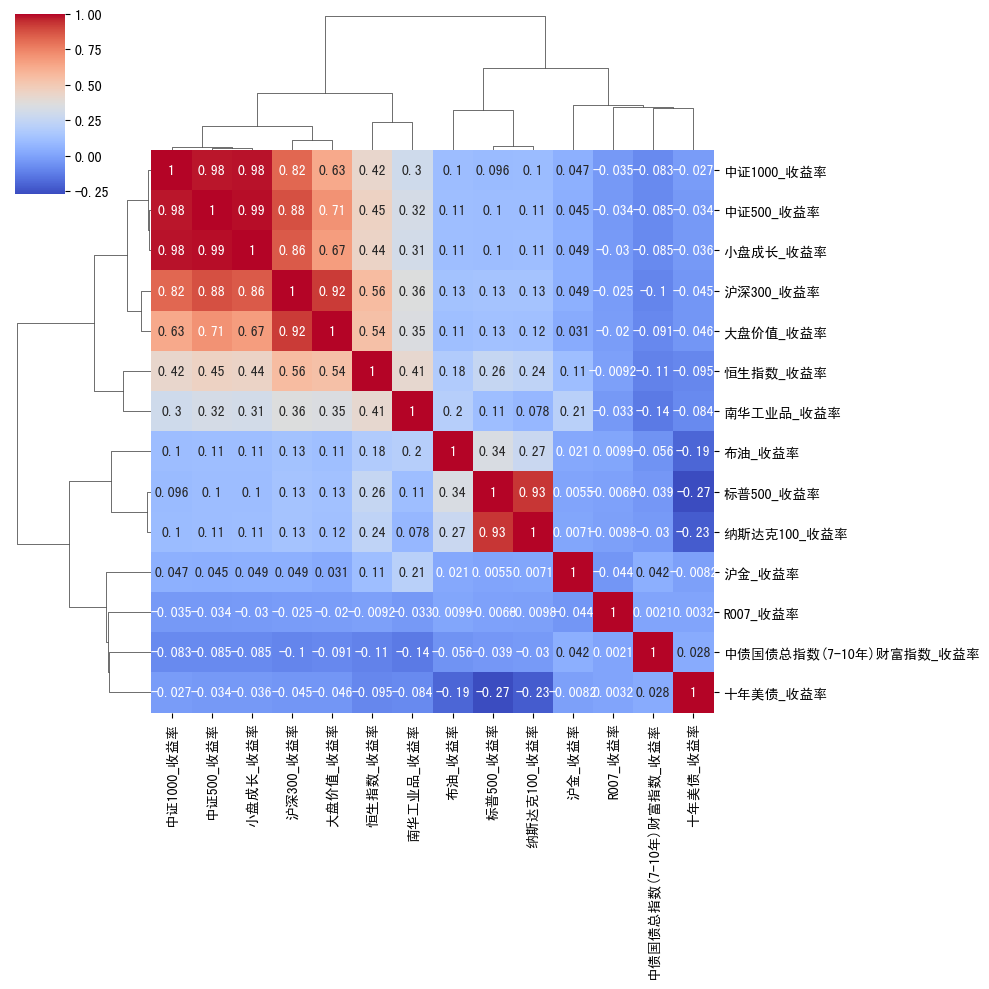

In [32]:
# 计算收益率之间的相关性矩阵并绘制聚类热图
corr_matrix = log_returns.corr()
sns.clustermap(corr_matrix, method='ward', cmap='coolwarm', annot=True)

In [11]:
# 提取资产名称
asset_names = [col.split('_')[0] for col in log_returns.columns]

# 计算技术指标
assets_features = pd.DataFrame()
for column in asset_names:
    # 短期和长期收益率
    assets_features[f'{column}_短期收益率'] = log_returns[f'{column}_收益率'].rolling(window=5).sum()
    assets_features[f'{column}_长期收益率'] = log_returns[f'{column}_收益率'].rolling(window=20).sum()
    # 波动率
    assets_features[f'{column}_波动率'] = log_returns[f'{column}_收益率'].rolling(window=20).std()

# 删除含有缺失值的行
assets_features.dropna(inplace=True)

In [12]:
# 显示计算得到的资产特征
assets_features.head(10)

,沪深300_短期收益率,沪深300_长期收益率,沪深300_波动率,中证500_短期收益率,中证500_长期收益率,中证500_波动率,中证1000_短期收益率,中证1000_长期收益率,中证1000_波动率,大盘价值_短期收益率,...,布油_波动率,十年美债_短期收益率,十年美债_长期收益率,十年美债_波动率,沪金_短期收益率,沪金_长期收益率,沪金_波动率,R007_短期收益率,R007_长期收益率,R007_波动率
2008-02-13,0.022135,-0.153259,0.035914,-0.007832,-0.106866,0.039590,-0.004118,-0.110937,0.038213,0.037663,...,0.016724,0.013118,0.017708,0.005315,-0.031337,-0.047847,0.016779,0.000383,0.001626,0.000021
2008-02-14,0.054715,-0.150372,0.035996,0.051598,-0.091774,0.039936,0.055363,-0.094092,0.038575,0.073621,...,0.016983,-0.002298,0.016976,0.005365,-0.019647,-0.011412,0.015319,0.000368,0.001631,0.000021
2008-02-15,0.051446,-0.168931,0.035902,0.091918,-0.095715,0.039927,0.096975,-0.092485,0.038575,0.073188,...,0.016788,-0.000552,0.013293,0.005262,-0.017167,-0.008299,0.015346,0.000358,0.001646,0.000020
2008-02-18,-0.007937,-0.154546,0.036342,0.045174,-0.076687,0.040585,0.046920,-0.082354,0.038926,0.001074,...,0.016136,0.001452,0.012752,0.005264,-0.003390,-0.019851,0.015277,0.000350,0.001659,0.000020
2008-02-19,0.019900,-0.126263,0.036951,0.059052,-0.066638,0.040797,0.060715,-0.074733,0.039116,0.023770,...,0.017652,-0.012645,-0.001137,0.005549,0.008104,-0.028551,0.014846,0.000350,0.001663,0.000020
2008-02-20,0.019051,-0.114774,0.036584,0.055727,-0.061619,0.040746,0.055420,-0.070374,0.039100,0.021820,...,0.017235,-0.014530,-0.001682,0.005553,0.030115,0.014967,0.014324,0.000351,0.001666,0.000019
2008-02-21,-0.000865,-0.095681,0.036282,0.048348,-0.022517,0.040497,0.049728,-0.035106,0.039017,-0.001559,...,0.017979,0.002953,0.004936,0.006014,0.035109,0.033762,0.014247,0.000385,0.001696,0.000020
2008-02-22,-0.023346,-0.141035,0.036785,0.028883,-0.055733,0.040749,0.034214,-0.062221,0.039144,-0.032587,...,0.018013,-0.000134,0.002523,0.006021,0.031985,0.042550,0.014058,0.000418,0.001728,0.000020
2008-02-25,-0.083012,-0.129704,0.036155,-0.035007,-0.045675,0.040295,-0.025020,-0.052212,0.038668,-0.084992,...,0.017298,-0.007408,-0.004751,0.006244,0.043689,0.042620,0.014059,0.000468,0.001774,0.000021
2008-02-26,-0.106057,-0.051435,0.031849,-0.052911,0.043441,0.034708,-0.042645,0.035129,0.033237,-0.104597,...,0.017536,0.004862,-0.011104,0.005853,0.015150,0.058747,0.012076,0.000510,0.001784,0.000022


In [13]:
# 调整特征的形状
assets_features_3d = np.zeros((len(assets_features), len(asset_names), 3))

for i, asset in enumerate(asset_names):
    # 提取该资产的所有特征
    short_return = assets_features[f'{asset}_短期收益率'].values
    long_return = assets_features[f'{asset}_长期收益率'].values
    volatility = assets_features[f'{asset}_波动率'].values
    
    # 将特征组织到3D数组中
    assets_features_3d[:, i, 0] = short_return
    assets_features_3d[:, i, 1] = long_return
    assets_features_3d[:, i, 2] = volatility

In [14]:
# 显示第一期的特征
assets_features_3d[0, :, :]

array([[ 2.21348224e-02, -1.53259221e-01,  3.59140262e-02],
       [-7.83241683e-03, -1.06865953e-01,  3.95899250e-02],
       [-4.11833237e-03, -1.10936513e-01,  3.82131538e-02],
       [ 3.76626173e-02, -1.40905720e-01,  3.75874952e-02],
       [-3.99804873e-03, -9.83667695e-02,  3.92553011e-02],
       [-2.06802115e-02, -1.75550967e-01,  4.56595516e-02],
       [ 9.58608221e-03,  2.45075653e-02,  2.03875594e-03],
       [ 1.40357675e-02, -2.53650486e-03,  1.17627666e-02],
       [ 8.37310530e-03, -3.02003257e-02,  1.66959482e-02],
       [ 7.98019386e-03, -6.69355363e-02,  1.74062654e-02],
       [-3.58506634e-02, -5.20912069e-02,  1.67243551e-02],
       [ 1.31177964e-02,  1.77080569e-02,  5.31523193e-03],
       [-3.13372759e-02, -4.78472965e-02,  1.67786094e-02],
       [ 3.83344959e-04,  1.62644710e-03,  2.12884938e-05]])

In [15]:
# 显示沪深300前20期的特征
assets_features_3d[:20, 0, :]

array([[ 0.02213482, -0.15325922,  0.03591403],
       [ 0.05471536, -0.15037208,  0.03599594],
       [ 0.05144649, -0.16893131,  0.03590219],
       [-0.00793667, -0.15454616,  0.03634203],
       [ 0.01989971, -0.12626325,  0.03695063],
       [ 0.01905145, -0.1147744 ,  0.03658412],
       [-0.00086549, -0.09568131,  0.03628164],
       [-0.023346  , -0.14103543,  0.03678457],
       [-0.08301197, -0.12970404,  0.03615544],
       [-0.10605669, -0.05143537,  0.03184892],
       [-0.05634824, -0.06978332,  0.03063272],
       [-0.05349174, -0.08402613,  0.03045745],
       [-0.0059063 , -0.08267213,  0.03049202],
       [ 0.05822174,  0.0123625 ,  0.0267884 ],
       [ 0.03388164, -0.01928031,  0.02735964],
       [-0.00238313, -0.01754509,  0.02732935],
       [ 0.01353269,  0.01389082,  0.02711446],
       [-0.01137354,  0.01082064,  0.02719001],
       [-0.07792751, -0.11065442,  0.02162877],
       [-0.05048386, -0.1027592 ,  0.02169687]])

In [16]:
# 准备模型输入数据
sequences_returns = []
targets_returns = []
targets_vol = []
days_num = len(assets_features_3d)
time_steps = 20

for i in range(days_num - time_steps - 20):
    sequence = assets_features_3d[i:i+time_steps]
    target_1 = np.zeros(len(assets.columns))
    target_2 = np.zeros(len(assets.columns))
    for j, asset in enumerate(assets.columns):
        target_1[j] = assets_features_3d[i+time_steps+20, j, 1]  # 长期收益率
        target_2[j] = assets_features_3d[i+time_steps+20, j, 2]  # 波动率
    
    sequences_returns.append(sequence)
    targets_returns.append(target_1)
    targets_vol.append(target_2)


X = np.array(sequences_returns)
y_returns = np.array(targets_returns)
y_vol = np.array(targets_vol)

In [17]:
X.shape, y_returns.shape, y_vol.shape

((4159, 20, 14, 3), (4159, 13), (4159, 13))

In [18]:
# 划分训练集和测试集
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_returns_train, y_returns_test = y_returns[:train_size], y_returns[train_size:]
y_vol_train, y_vol_test = y_vol[:train_size], y_vol[train_size:]

In [19]:
X_train.shape, X_test.shape, y_returns_train.shape, y_returns_test.shape, y_vol_train.shape, y_vol_test.shape

((3535, 20, 14, 3),
 (624, 20, 14, 3),
 (3535, 13),
 (624, 13),
 (3535, 13),
 (624, 13))

# 模型构建与训练

## 模型架构
1. 输入层：处理多维时序特征
2. 重塑层：调整特征维度适配LSTM
3. LSTM层：64个隐藏单元，带dropout
4. 全连接层：32节点降维
5. 输出层：预测目标收益率

## 训练策略
- 批次大小：32
- 学习率：1e-5 
- 早停机制：验证损失10轮无改善
- 验证集比例：20%

In [20]:
# 设置随机种子
keras.utils.set_random_seed(42)

2025-06-08 19:55:49.540230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749383749.563078    2671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749383749.569888    2671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749383749.587461    2671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749383749.587488    2671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749383749.587490    2671 computation_placer.cc:177] computation placer alr

In [21]:
# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [22]:
# 转换为张量并移动到设备
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)

In [23]:
# 训练资产长期收益率的LSTM模型
lstm_returns_histories = {}  # 存储每个资产的训练历史
lstm_returns_models = {}     # 存储每个资产的模型

for asset_idx, asset_name in enumerate(assets.columns):
    print(f"\n开始训练 {asset_name} 的长期收益率预测模型")
    
    # 准备当前资产的目标数据
    y_train_target = y_returns_train[:, asset_idx]
    y_test_target = y_returns_test[:, asset_idx]
    
    # 将数据转换为GPU张量（如果可用）
    y_train_tensor = torch.FloatTensor(y_train_target).to(device)
    y_test_tensor = torch.FloatTensor(y_test_target).to(device)
    
    """构建LSTM模型架构
    1. 输入层：处理时序特征
    2. Reshape层：调整特征维度以适应LSTM
    3. LSTM层：处理序列信息，64个隐藏单元
    4. Dropout层：防止过拟合
    5. Dense层：特征降维和非线性变换
    6. 输出层：预测单个值
    """
    inputs = Input(shape=(X.shape[1], X.shape[2], X.shape[3]))
    x = Reshape((X.shape[1], -1))(inputs)  # 将3D特征展平为2D序列
    x = LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.2)(x)  # LSTM主体
    x = Dropout(0.4)(x)  # 防止过拟合
    x = Dense(32, activation='relu')(x)  # 降维
    x = Dropout(0.3)(x)  # 额外的正则化
    outputs = Dense(1)(x)  # 输出预测值
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 配置优化器和损失函数
    adam_optimizer = Adam(0.00001)  # 使用较小的学习率以确保稳定训练
    model.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
    
    # 将模型移至GPU（如果可用）
    model.to(device)

    early_stopping = EarlyStopping(
        monitor='val_loss',  # 监控验证集损失
        patience=10,          # 容忍5个epoch无改善
        mode='min',          # 监控指标需最小化（损失类）
        restore_best_weights=True  # 恢复最佳权重
        )
    
    def piecewise_schedule(epoch):
        if epoch < 5:  
            return 0.00005
        elif epoch < 15:
            return 0.00003
        else:             
            return 0.00001

    scheduler = LearningRateScheduler(piecewise_schedule)

    # 模型训练，使用验证集监控训练过程
    history = model.fit(
        X_train_tensor, y_train_tensor,
        epochs=100,
        batch_size=32,
        validation_split=0.2,  # 30%数据用于验证
        callbacks=[early_stopping, scheduler],
        verbose=1
    )
    
    # 保存模型和训练历史
    lstm_returns_models[asset_name] = model
    lstm_returns_histories[asset_name] = history.history


开始训练 沪深300 的长期收益率预测模型
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0071 - mae: 0.0609 - val_loss: 0.0029 - val_mae: 0.0419 - learning_rate: 5.0000e-05
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0066 - mae: 0.0595 - val_loss: 0.0029 - val_mae: 0.0421 - learning_rate: 5.0000e-05
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0070 - mae: 0.0607 - val_loss: 0.0029 - val_mae: 0.0421 - learning_rate: 5.0000e-05
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0062 - mae: 0.0586 - val_loss: 0.0029 - val_mae: 0.0421 - learning_rate: 5.0000e-05
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0067 - mae: 0.0601 - val_loss: 0.0029 - val_mae: 0.0420 - learning_rate: 5.0000e-05
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0068 - mae: 0.0601 - val_loss: 0.0029 - val_mae: 0.0420 - learning_rate: 3.0000e-05
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0068 - mae: 0.0597 - val_loss: 0.0029 -

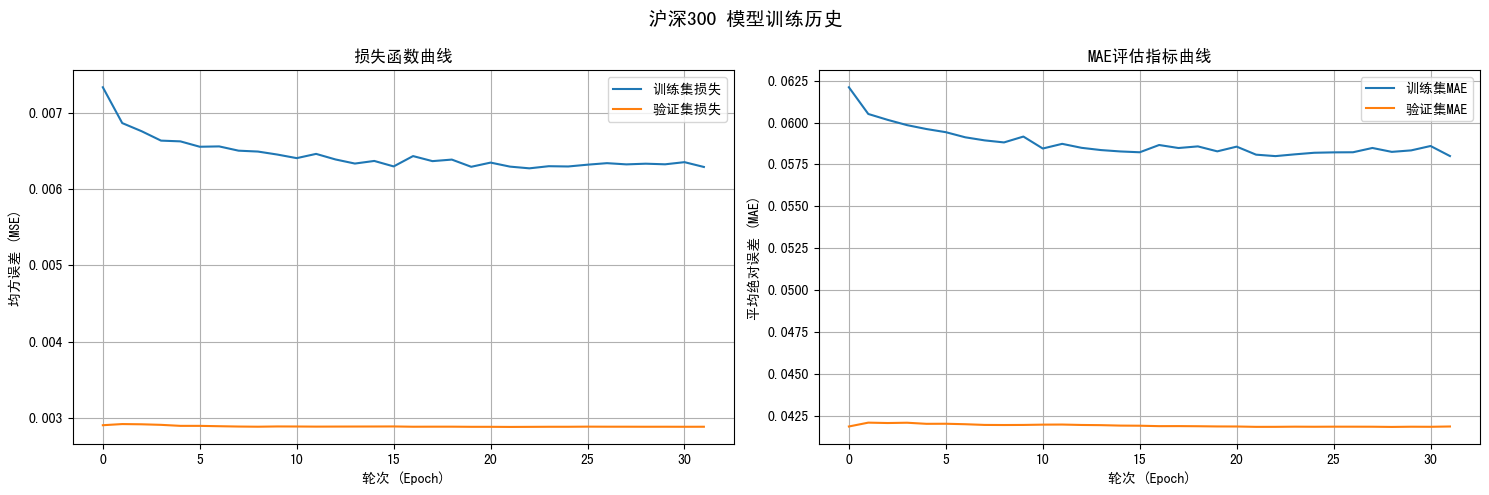

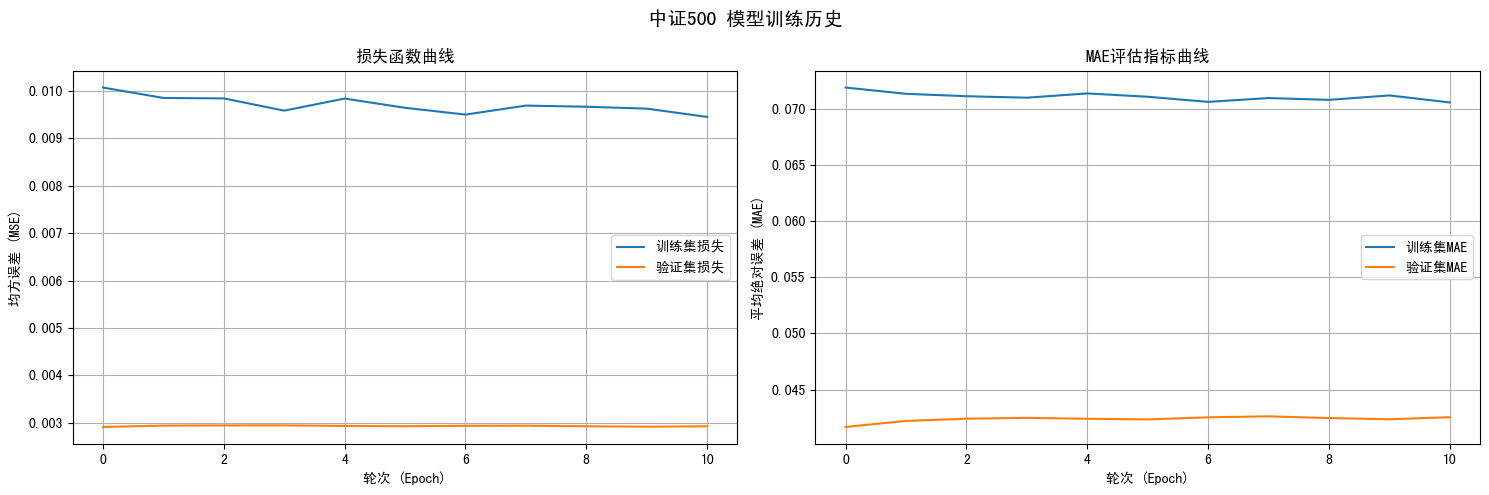

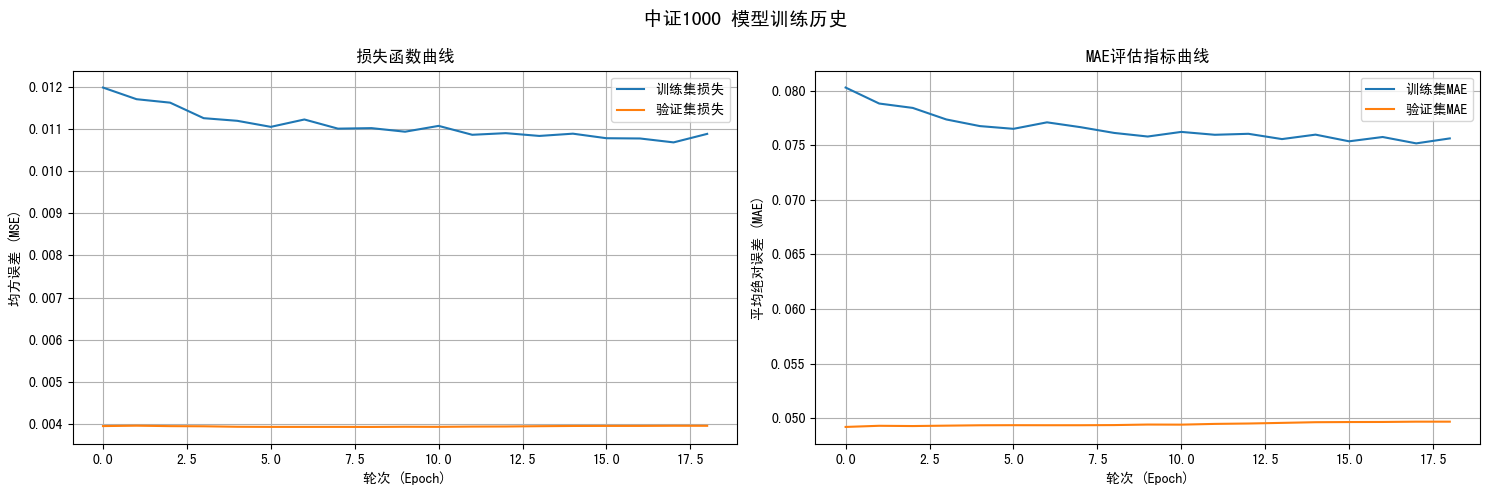

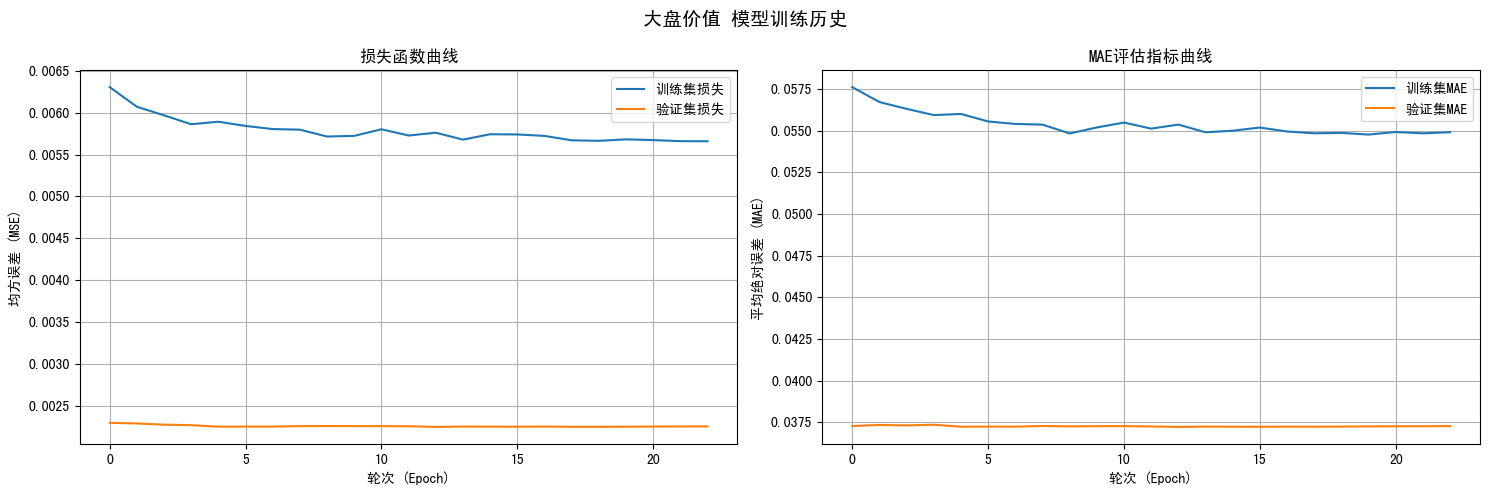

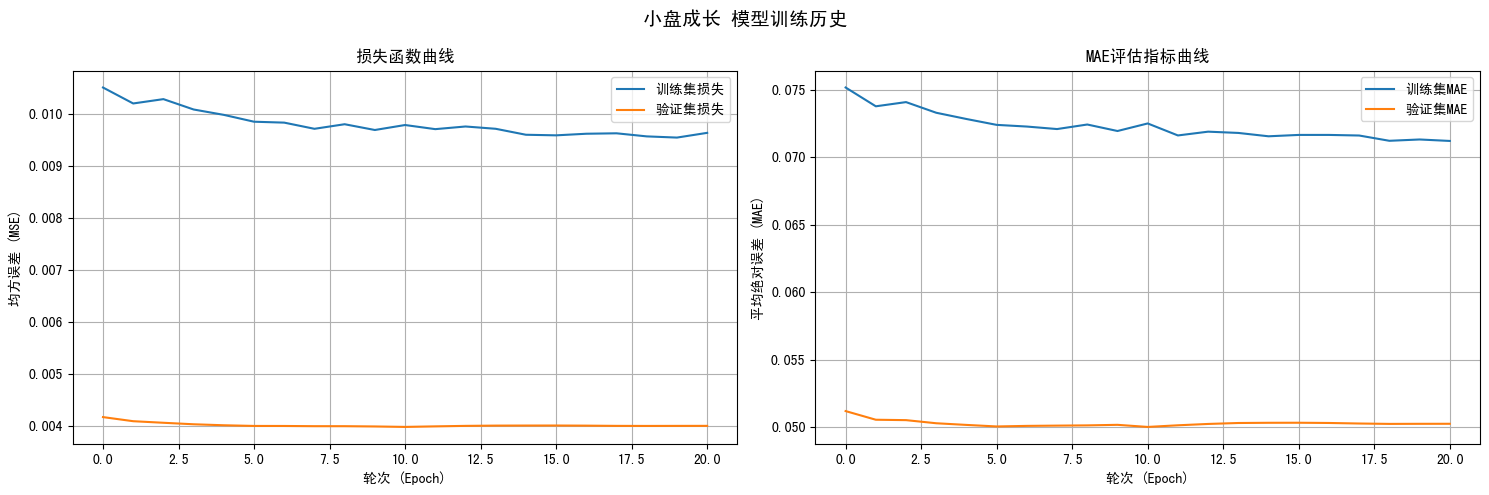

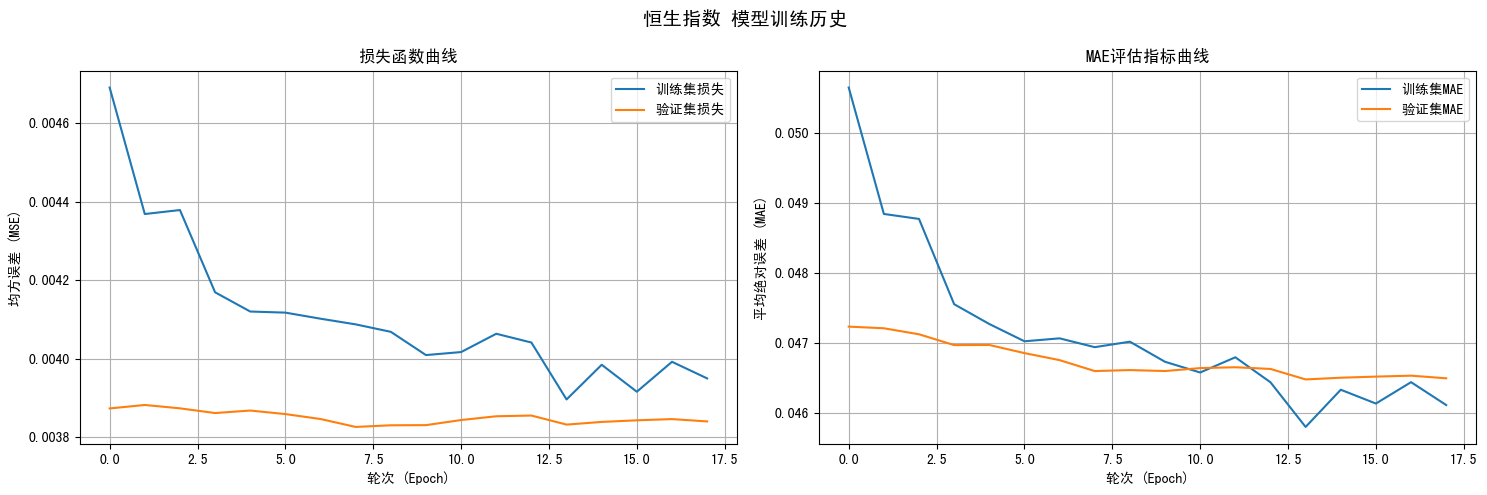

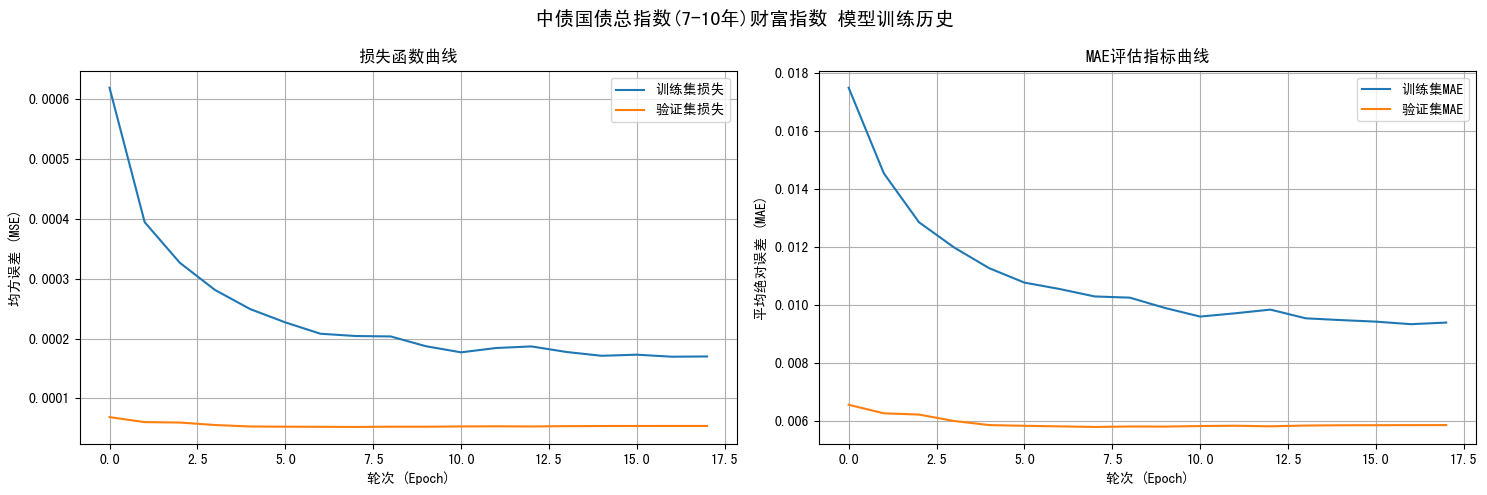

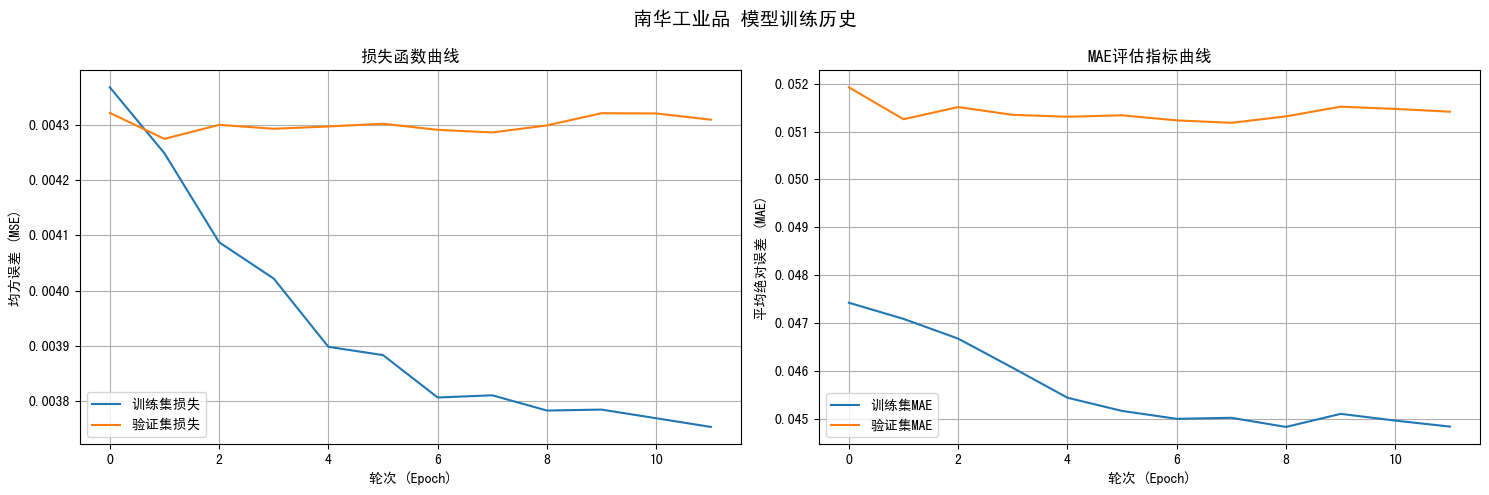

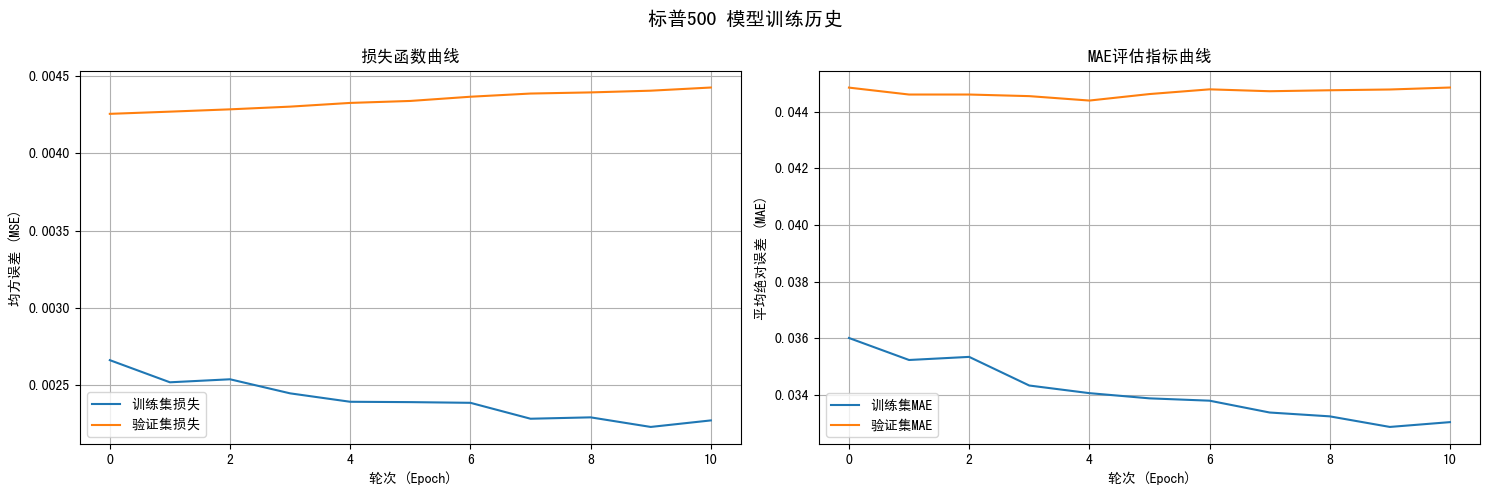

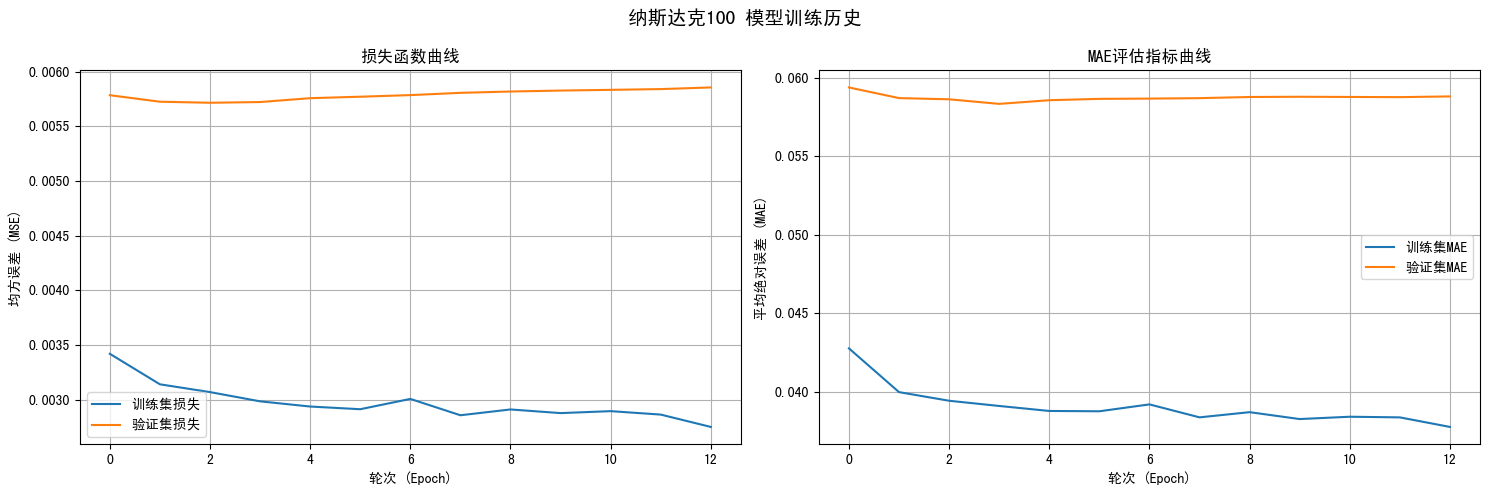

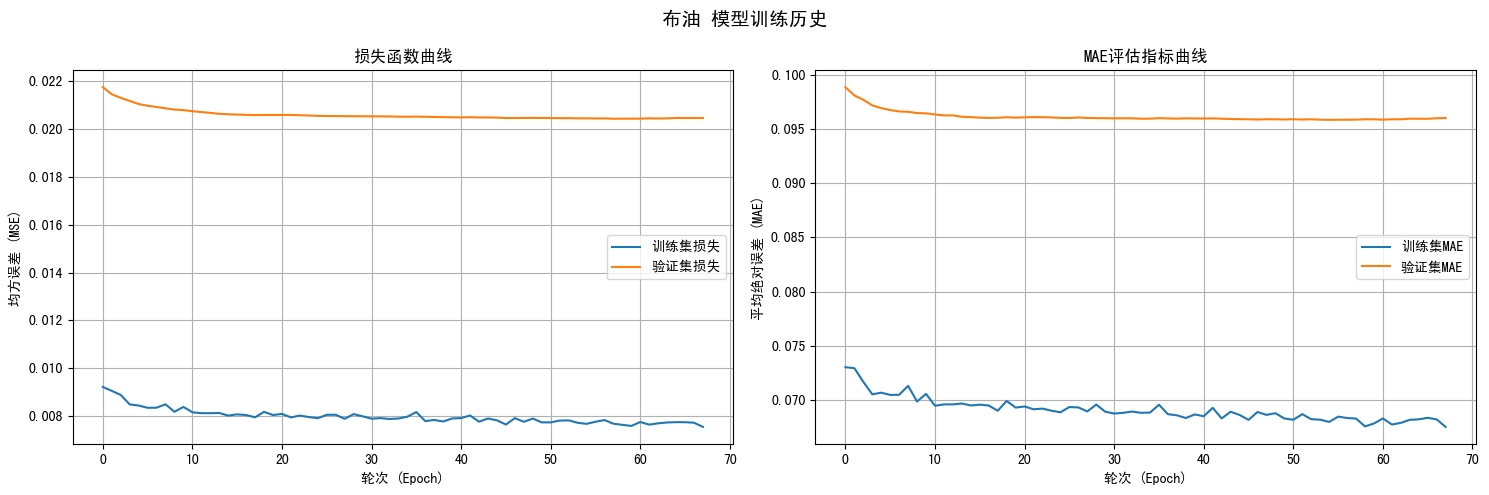

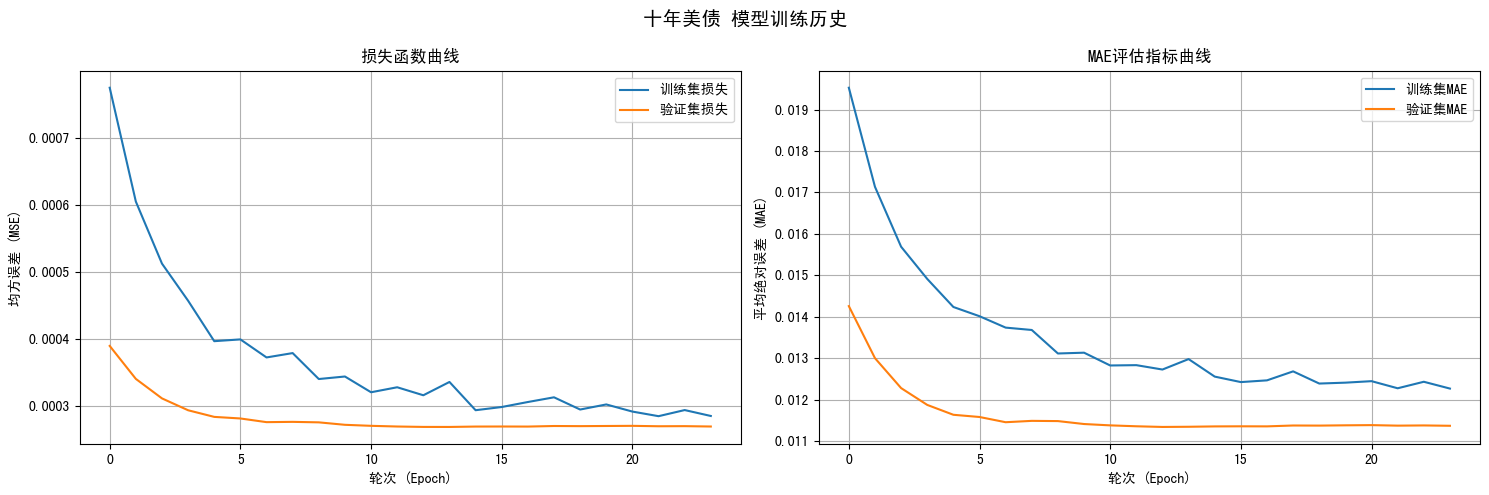

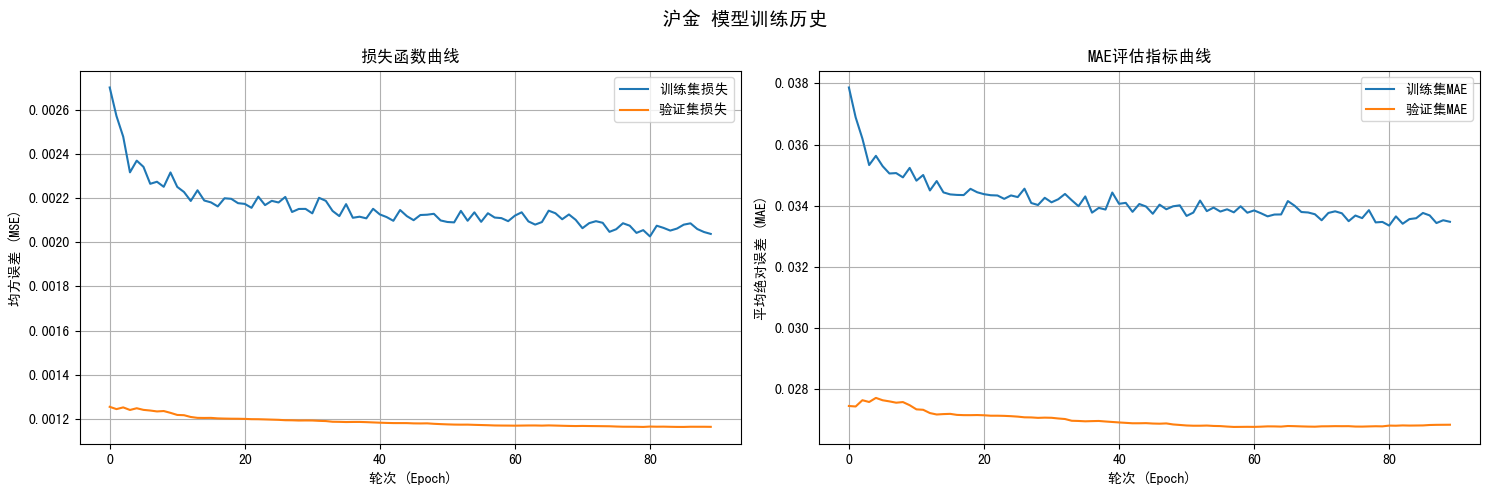

In [24]:
# 绘制每个资产的学习曲线
for asset_name in assets.columns:
    history = lstm_returns_histories[asset_name]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{asset_name} 模型训练历史', fontsize=14)
    
    # 损失函数曲线
    ax1.plot(history['loss'], label='训练集损失')
    ax1.plot(history['val_loss'], label='验证集损失')
    ax1.set_xlabel('轮次 (Epoch)')
    ax1.set_ylabel('均方误差 (MSE)')
    ax1.set_title('损失函数曲线')
    ax1.legend()
    ax1.grid(True)
    
    # MAE指标曲线
    ax2.plot(history['mae'], label='训练集MAE')
    ax2.plot(history['val_mae'], label='验证集MAE')
    ax2.set_xlabel('轮次 (Epoch)')
    ax2.set_ylabel('平均绝对误差 (MAE)')
    ax2.set_title('MAE评估指标曲线')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [27]:
# 评估LSTM基准模型性能
lstm_returns_metrics = []
pred_return = {}

print("\n长期收益率LSTM基准模型评估结果：")
for asset_idx, asset_name in enumerate(assets.columns):
    model = lstm_returns_models[asset_name]
    y_true = y_returns_test[:, asset_idx]
    y_pred = model.predict(X_test_tensor).flatten()
    pred_return[asset_name] = y_pred
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    lstm_returns_metrics.append({
        '资产': asset_name,
        'MSE (LSTM)': mse,
        'MAE (LSTM)': mae,
        'R2 (LSTM)': r2,
    })

lstm_returns_df = pd.DataFrame(lstm_returns_metrics)
lstm_returns_df.set_index('资产', inplace=True)

pred_return_df = pd.DataFrame(pred_return, index=log_returns.index[-len(y_returns_test):])

lstm_returns_df


长期收益率LSTM基准模型评估结果：
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


,MSE (LSTM),MAE (LSTM),R2 (LSTM)
资产,,,
沪深300,0.002482,0.035796,0.023248
中证500,0.003830,0.044363,0.020604
中证1000,0.005530,0.053935,0.022043
大盘价值,0.002003,0.032231,-0.016722
小盘成长,0.004884,0.051147,0.006792
恒生指数,0.005597,0.057960,-0.009419
中债国债总指数(7-10年)财富指数,0.000052,0.005339,-0.072262
南华工业品,0.001498,0.030958,-0.061413
标普500,0.001773,0.034724,-0.127391


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


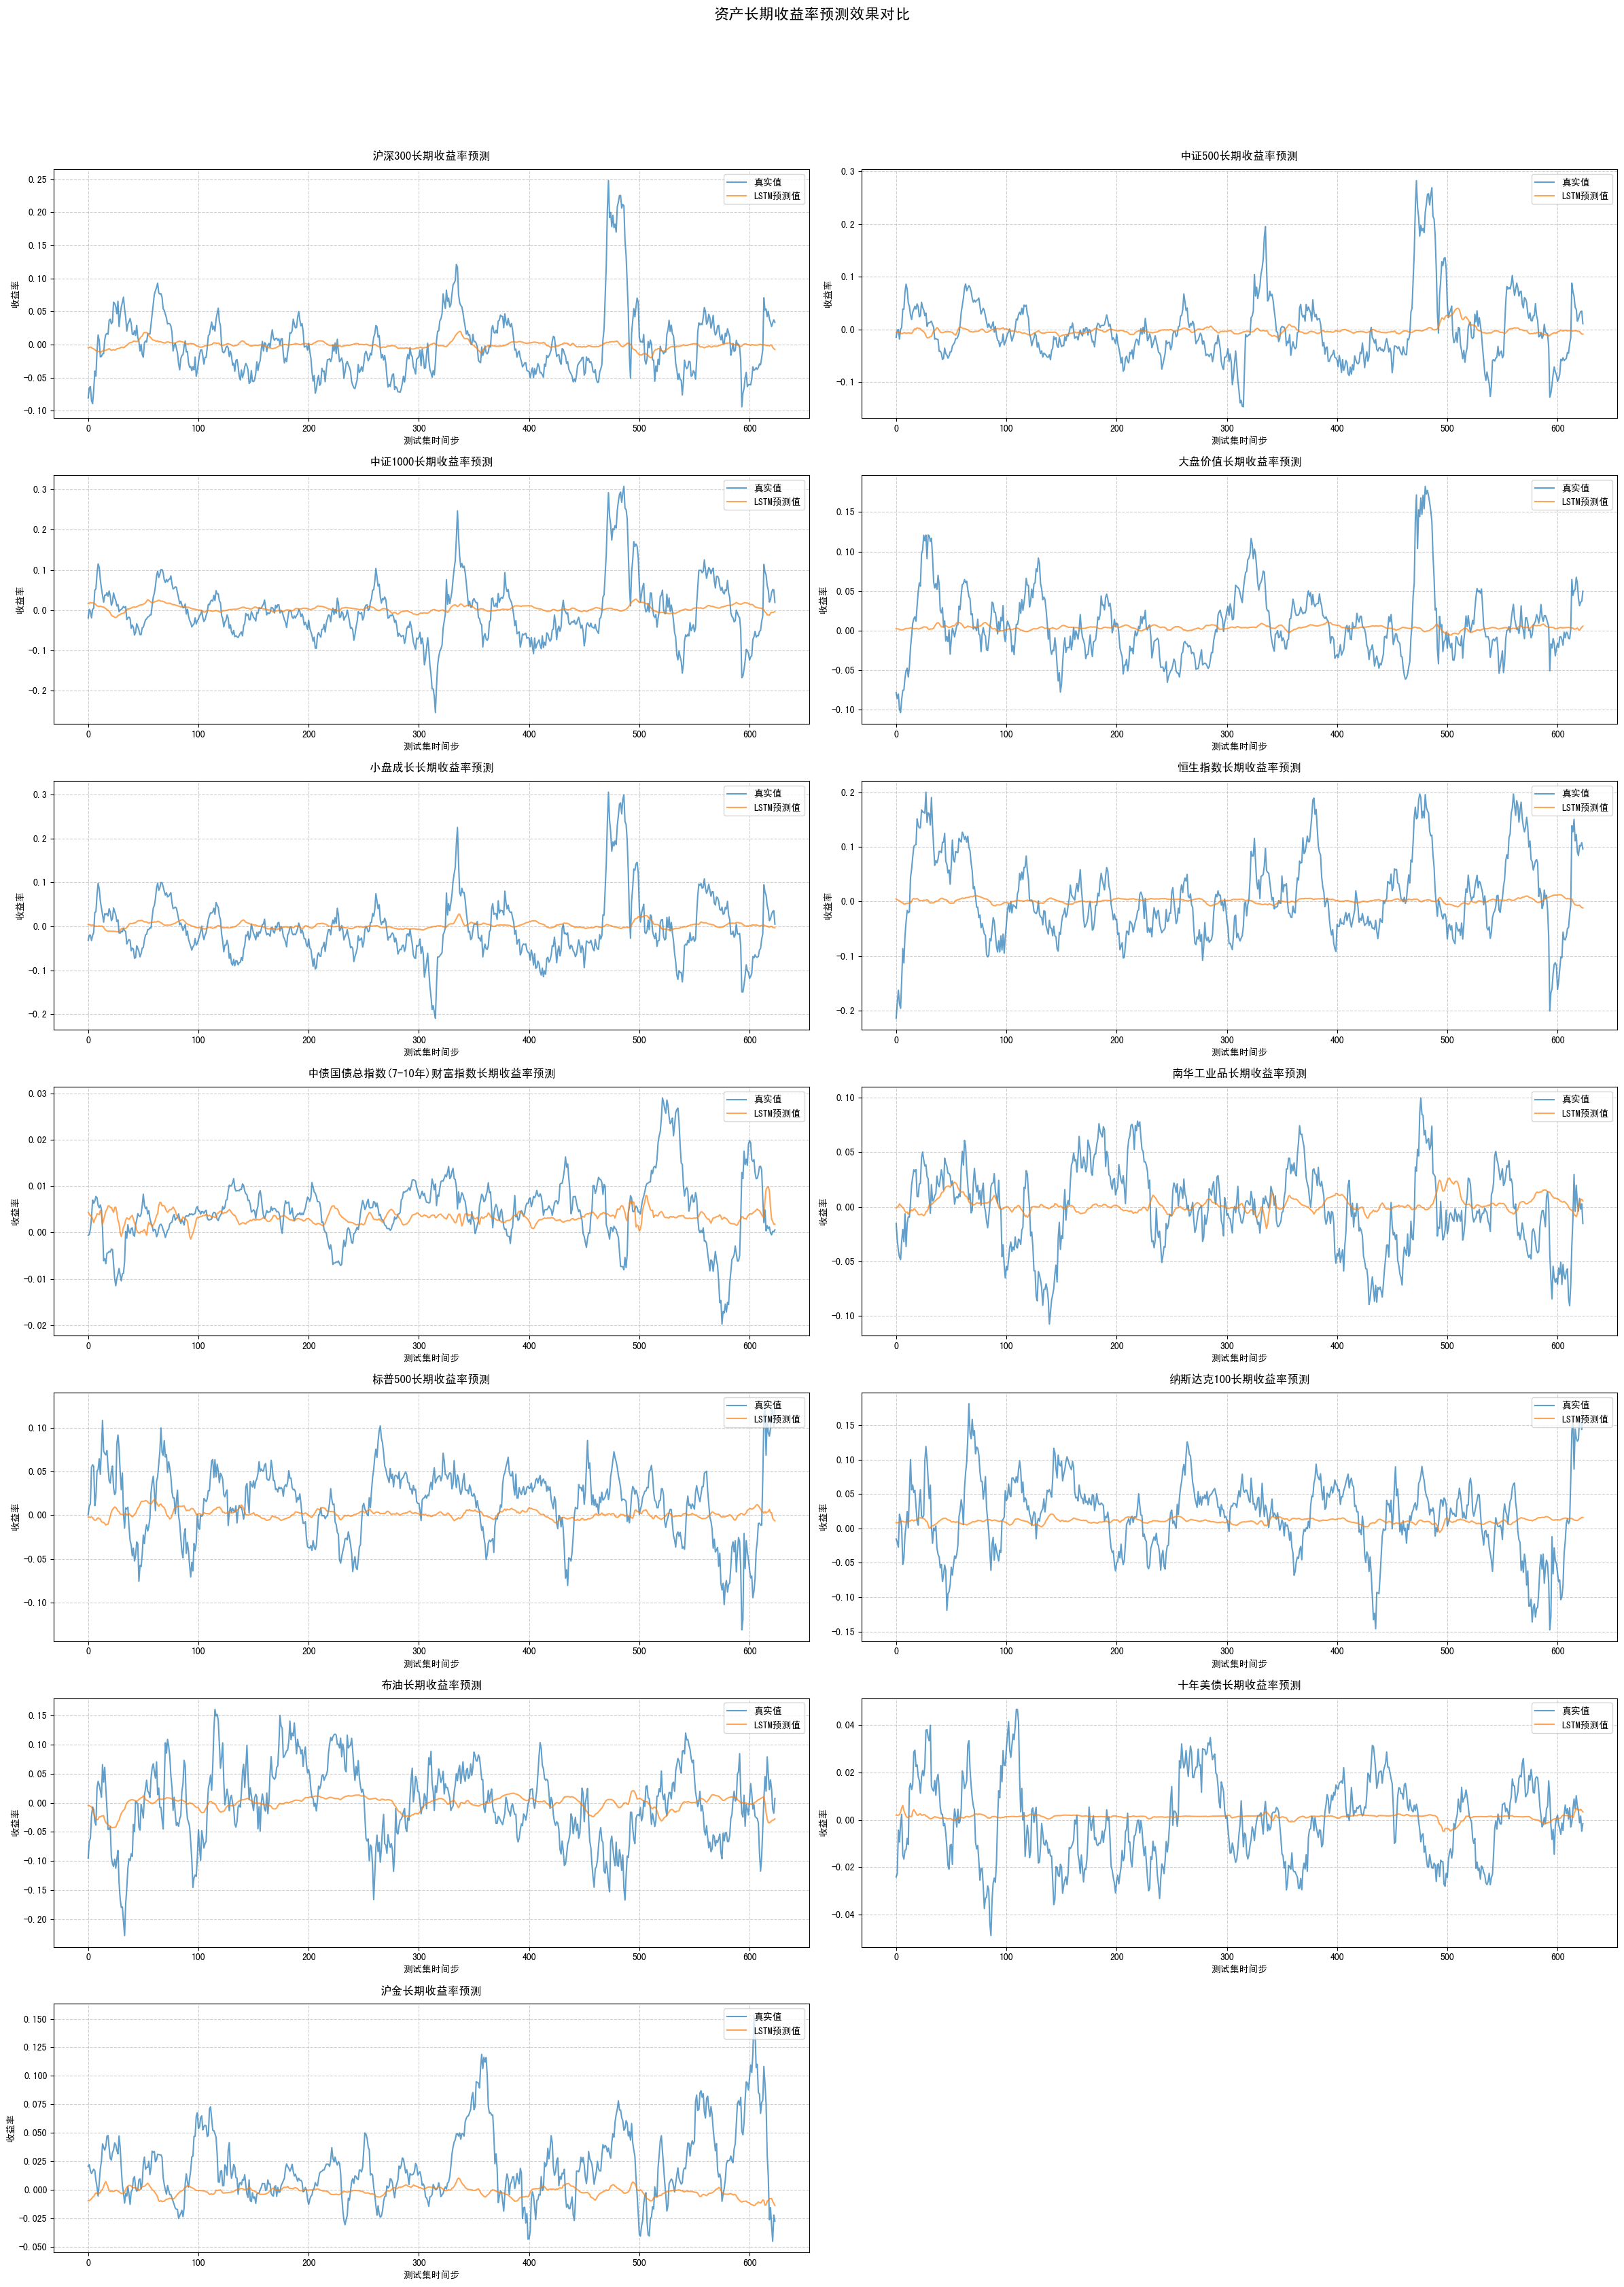

In [26]:
# 可视化每个资产的预测结果
n_assets = len(assets.columns)
n_cols = min(2, n_assets)  # 每行最多显示2个子图
n_rows = (n_assets + n_cols - 1) // n_cols  # 计算所需的行数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 32))
fig.suptitle('资产长期收益率预测效果对比', fontsize=16, y=1.05)

for idx, asset_name in enumerate(assets.columns):
    # 计算子图位置
    row = idx // n_cols
    col = idx % n_cols
    
    # 获取预测结果
    model = lstm_returns_models[asset_name]
    y_true = y_returns_test[:, idx]  # 真实值
    y_pred = model.predict(X_test_tensor).flatten()  # 预测值
    
    # 绘制对比图
    ax = axes[row, col]
    ax.plot(y_true, label='真实值', alpha=0.7)
    ax.plot(y_pred, label='LSTM预测值', alpha=0.7)
    ax.set_title(f'{asset_name}长期收益率预测', pad=10)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('测试集时间步')
    ax.set_ylabel('收益率')

# 移除多余的空白子图（如果有）
if n_assets % 2 != 0:
    axes[-1, -1].remove()

plt.tight_layout()
plt.show()

In [28]:
pred_return_df

,沪深300,中证500,中证1000,大盘价值,小盘成长,恒生指数,中债国债总指数(7-10年)财富指数,南华工业品,标普500,纳斯达克100,布油,十年美债,沪金
2022-10-25,-0.004797,-0.005502,0.016049,0.002415,0.004195,0.004663,0.004342,-0.001237,-0.002261,0.008469,-0.004182,0.002002,-0.009547
2022-10-26,-0.004446,-0.004541,0.017168,0.002127,0.003695,0.003048,0.004040,-0.000360,-0.002143,0.008200,-0.005089,0.001944,-0.009381
2022-10-27,-0.003762,-0.005081,0.018641,0.002092,0.003329,0.002151,0.003591,0.000454,-0.002364,0.008522,-0.006079,0.002007,-0.008649
2022-10-28,-0.004807,-0.005352,0.017960,0.001455,0.002190,0.000983,0.003587,0.002691,-0.001759,0.009198,-0.006930,0.002234,-0.007787
2022-10-31,-0.005806,-0.007311,0.017806,0.000941,0.003082,-0.000077,0.002909,0.001511,-0.002875,0.009499,-0.011238,0.003271,-0.006348
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-16,-0.000537,-0.003593,-0.007986,0.001170,-0.000371,-0.007151,0.005394,-0.000151,0.003058,0.012332,-0.032842,0.004388,-0.007591
2025-05-19,-0.000829,-0.004045,-0.005751,0.000499,-0.000099,-0.006661,0.002960,0.003156,0.002628,0.013886,-0.030720,0.004047,-0.007505
2025-05-20,-0.004276,-0.006748,-0.006448,0.002635,-0.002280,-0.009386,0.002371,0.006697,-0.003460,0.014754,-0.030120,0.004492,-0.009977
2025-05-21,-0.006232,-0.008732,-0.005302,0.004244,-0.003025,-0.011144,0.001781,0.006780,-0.005395,0.016007,-0.029182,0.003891,-0.012005


In [33]:
pred_return_df.to_csv('资产收益率预测结果.csv', index=True)